<a href="https://colab.research.google.com/github/Abel-Lagonell/Data-Mining/blob/main/Homework04_Abel_Lagonell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%pip install dmba

import dmba
from dmba import printTermDocumentMatrix

import sklearn.feature_extraction.text as text
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Question 1

The, laptop, was, difficult, to, set, up, ,, and, 

difficult, to, connect, to, the, WIFI, ., I, would, go, 

back, to, using, the, previous, laptop, except, it, no, longer, 

charges, ., -------------------------------------



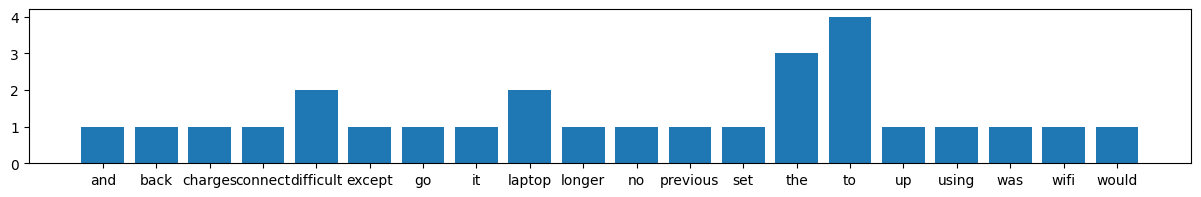

-------------------------------------



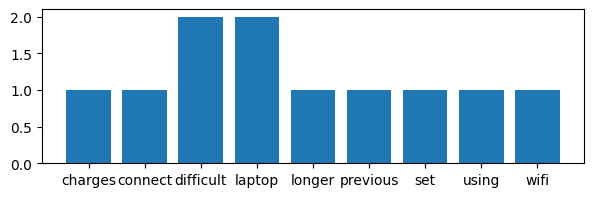

-------------------------------------



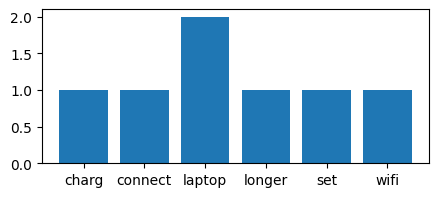

-------------------------------------

{'neg': 0.288, 'neu': 0.712, 'pos': 0.0, 'compound': -0.8074}


In [ ]:
def plot_word_freq(vector, count, width=10):
    plt.figure(figsize=(width, 2))
    plt.bar(vector.get_feature_names_out(), np.ravel(count.sum(axis=0)))
    plt.show()

sample_text = "The laptop was difficult to set up, and difficult to connect to the WIFI. I would go back to using the previous laptop except it no longer charges."

#A
word_tokens = nltk.word_tokenize(sample_text)
for i, word in enumerate(word_tokens):
    if i%10 == 9: print('\n')
    print(word, end=', ')
print('-------------------------------------\n')
#B: Determine and plot the word frequency for the sample text.
count_vector = text.CountVectorizer()
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=15)
print('-------------------------------------\n')
#C
count_vector = text.CountVectorizer(stop_words='english')
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=7)
print('-------------------------------------\n')
#D
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = ENGLISH_STOP_WORDS
        self.nouns = ['NN', 'NNS', 'NNP', 'NNPS']

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)
                if t.isalpha() and t not in self.stopWords and nltk.pos_tag([t])[0][1] in self.nouns]

count_vector = text.CountVectorizer(tokenizer=LemmaTokenizer())
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=5)
print('-------------------------------------\n')
#E
sentiment = SentimentIntensityAnalyzer()
print(sentiment.polarity_scores(sample_text))

# Question 2

In [ ]:
sample_text = r"""Thanks John!<br /><br /><font size=”3”>
&quot;Illustrations and demos will be
provided for students to work through on
their own&quot;</font>.
Do we need that to finish project? If yes,
where to find the illustration and demos?
Thanks for your help.\<img title=”smile”
alt=”smile” src=”\url{http://lms.statistics.com/pix/smartpix.php/statistics_com_1/s/smiley.gif}” \>
<br /> <br />
"""

# A
tokens = word_tokenize(sample_text)
non_words = [word for word in tokens if not word.isalpha()]
for i, word in enumerate(non_words):
    if i%11 == 10: print('\n')
    print(word, end='  ')
print('-------------------------------------\n')
# B
# We can remove all html tokens such as <, >, alt=, we can also remove anything between angle brackets
# C
# Words that we want are Demos, provided, project, help, illustration, find
# D
# Bag of words just get the different words and lose the bigger picture meaning of the actual text.

!  <  /  >  <  /  >  <  size=  ”  

3  ”  >  &  ;  &  ;  <  /font  >  .  

?  ,  ?  help.\  <  title=  ”  ”  alt=  ”  ”  

src=  ”  \url  {  :  //lms.statistics.com/pix/smartpix.php/statistics_com_1/s/smiley.gif  }  ”  \  >  <  

/  >  <  /  >  

# Question 3

In [52]:
import numpy as np
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# A) Load the data
corpus = []
labels = []

with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as rawData:
    for info in rawData.infolist():
        if info.is_dir():
            continue
        labels.append(1 if 'rec.autos' in info.filename else 0)
        try:
            corpus.append(rawData.read(info).decode('utf-8'))
        except UnicodeDecodeError:
            corpus.append(rawData.read(info).decode('latin-1'))

# B) Preprocess the documents
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokens = [[stemmer.stem(word) for word in word_tokenize(doc) if word.isalpha() and word not in stop_words] for doc in corpus]
X = tokens

# C) Create the concept matrix using LSA
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(corpus)

lsa = TruncatedSVD(n_components=10)
X_concepts = lsa.fit_transform(X_tfidf)

# D) Train a classification model
X_train, X_test, y_train, y_test = train_test_split(X_concepts, labels, test_size=0.4, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# E) Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1-score: {f1_score(y_test, y_pred):.2f}')


Accuracy: 0.92
Precision: 0.95
Recall: 0.89
F1-score: 0.92


#Question 4

In [55]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# A) Load the data
df = dmba.load_data('farm-ads.csv', header=None)
X = df[1].tolist()
y = df[0].tolist()

# B) Preprocess the data
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokens = [[stemmer.stem(word) for word in word_tokenize(doc) if word.isalpha() and word not in stop_words] for doc in X]
X_preprocessed = tokens

# C) Examine the term-document matrix
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

print(f'The term-document matrix is {"dense" if X_tfidf.getnnz() / X_tfidf.size > 0.5 else "sparse"}.')

# Find two non-zero entries and interpret their meaning
doc_idx = 0
word_idx = 1
print(f'The entry at (doc={doc_idx}, word={tfidf.get_feature_names_out()[word_idx]}) has value {X_tfidf[doc_idx, word_idx]:.2f}.')
print(f'This indicates that the word "{tfidf.get_feature_names_out()[word_idx]}" appears in document {doc_idx} with a weighted frequency of {X_tfidf[doc_idx, word_idx]:.2f}.')

# D) Concept-document matrix vs term-document matrix
lsa = TruncatedSVD(n_components=20)
X_concepts = lsa.fit_transform(X_tfidf)

print('The concept-document matrix represents the documents in a lower-dimensional space, where each column corresponds to a latent concept extracted from the text data. This is similar to the principal components in PCA, where the columns represent the directions of maximum variance in the data.')

# E) Train a classification model
X_train, X_test, y_train, y_test = train_test_split(X_concepts, y, test_size=0.4, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1-score: {f1_score(y_test, y_pred):.2f}')

print("Its able to differentiate the different true value pretty well but when it comes to getting negative values it doesnt do as well singling them out")
print("Concept Matrix will provide connections to various things allowing for better prediction of what class is going to be. Just giving frequencies wouldn't be as powerful of a tool as it just gives the amount with no other information")

The term-document matrix is dense.
The entry at (doc=0, word=aaa) has value 0.30.
This indicates that the word "aaa" appears in document 0 with a weighted frequency of 0.30.
The concept-document matrix represents the documents in a lower-dimensional space, where each column corresponds to a latent concept extracted from the text data. This is similar to the principal components in PCA, where the columns represent the directions of maximum variance in the data.
Accuracy: 0.85
Precision: 0.82
Recall: 0.92
F1-score: 0.87


# Question 5

Estimated number of natural clusters: 5-10


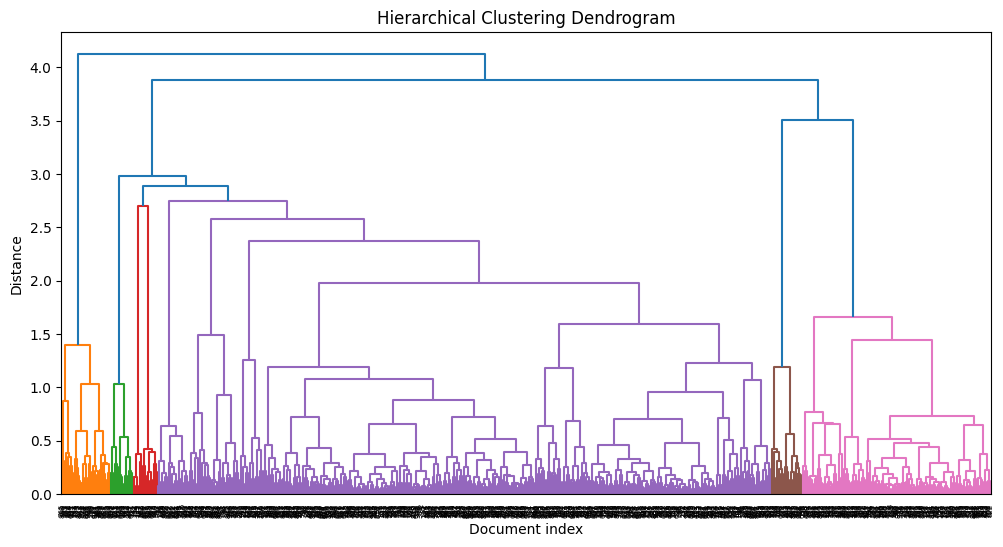

In [58]:
import numpy as np
from zipfile import ZipFile
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans

# A) Preprocess the auto-related posts
corpus = []
with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as rawData:
    for info in rawData.infolist():
        if info.is_dir() or 'rec.autos' not in info.filename:
            continue
        try:
            corpus.append(rawData.read(info).decode('utf-8'))
        except UnicodeDecodeError:
            corpus.append(rawData.read(info).decode('latin-1'))

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokens = [[stemmer.stem(word) for word in word_tokenize(doc) if word.isalpha() and word not in stop_words] for doc in corpus]
X = tokens

# B) Apply Latent Semantic Analysis (LSA)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(corpus)

lsa = TruncatedSVD(n_components=10)
X_concepts = lsa.fit_transform(X_tfidf)

# C) Estimate the number of natural clusters
# Based on the domain knowledge, I expect around 5-10 natural clusters in the auto-related posts
print(f'Estimated number of natural clusters: 5-10')

# D) Perform hierarchical clustering and inspect the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_matrix = linkage(X_concepts, 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Document index')
plt.ylabel('Distance')
plt.show()


In [62]:
# E) Determine the number of natural clusters from the dendrogram
# The dendrogram suggests around 6 natural clusters in the data because of the 6 different cluster colors

# F) Examine a sub-cluster
cluster_labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(X_concepts)
sub_cluster = [corpus[i] for i in range(len(corpus)) if cluster_labels[i] == 2]

print('Sub-cluster characteristics:')
for post in sub_cluster[:3]:
    print(post, '\n')

print("They seem to be around in April of the same year, some have a heading of the eternal champion, both from the news group rec.autos")

# G) Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred = kmeans.fit_predict(X_concepts)

between_cluster_distance = np.sqrt(kmeans.inertia_)
within_cluster_dispersion = np.mean(kmeans.transform(X_concepts))

print(f'Between-cluster distance: {between_cluster_distance:.2f}')
print(f'Within-cluster dispersion: {within_cluster_dispersion:.2f}')
print('The clusters are reasonably well-separated, and within clusters seem to bunched up too.')

Sub-cluster characteristics:
Path: cantaloupe.srv.cs.cmu.edu!rochester!cornell!batcomputer!caen!zaphod.mps.ohio-state.edu!malgudi.oar.net!news.ysu.edu!yfn.ysu.edu!ak296
From: ak296@yfn.ysu.edu (John R. Daker)
Newsgroups: rec.autos
Subject: Toyota wagons
Date: 5 Apr 1993 20:55:17 GMT
Organization: St. Elizabeth Hospital, Youngstown, OH
Lines: 9
Message-ID: <1pq6bl$9rj@news.ysu.edu>
Reply-To: ak296@yfn.ysu.edu (John R. Daker)
NNTP-Posting-Host: yfn.ysu.edu


Has anybody noticed that Toyota has an uncanny knack for designing horrible
ugly station wagons?  Tercels, Corollas, Camrys.  Have their designers no
aesthetic sense at all?
-- 
DoD #650<----------------------------------------------------------->DarkMan
   The significant problems we face cannot be solved at the same level of
      thinking we were at when we created them.   - Albert Einstein
         ___________________The Eternal Champion_________________
 

Path: cantaloupe.srv.cs.cmu.edu!rochester!cornell!batcomputer!caen!zaphod

#Question 6

In [65]:
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from collections import Counter

# A) Load the electronics-related posts
corpus = []
with ZipFile(dmba.get_data_file('AutoAndElectronics.zip')) as rawData:
    for info in rawData.infolist():
        if info.is_dir() or 'sci.electronics' not in info.filename:
            continue
        try:
            corpus.append(rawData.read(info).decode('utf-8'))
        except UnicodeDecodeError:
            corpus.append(rawData.read(info).decode('latin-1'))

# B) Preprocess the text data
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokens = [[stemmer.stem(word) for word in word_tokenize(doc) if word.isalpha() and word not in stop_words] for doc in corpus]

# C) Identify the 10 most frequent trigrams
all_trigrams = [tuple(tokens[i][j:j+3]) for i in range(len(tokens)) for j in range(len(tokens[i])-2)]
trigram_counts = Counter(all_trigrams)
top_trigrams = trigram_counts.most_common(10)

print('Top 10 frequent trigrams in electronics posts:')
for trigram, count in top_trigrams:
    print(f'{" ".join(trigram)}: {count}')

# D) Analyze the frequent trigrams
# The most frequent ones are talking about annual reports and also probably talking about either due dates or referring to a specific one
# Others are talking about meeting up to discuss the annual reports in the beginning of the week
# Lastly some are just talking about specific things in an article or report and one is asking to meet about it

Top 10 frequent trigrams in electronics posts:
apr gmt line: 425
date apr gmt: 316
newsgroup subject re: 289
line in articl: 249
path rochest udel: 185
apr gmt organ: 168
apr gmt refer: 144
gmt line in: 136
date mon apr: 130
date tue apr: 130
